In [3]:
%matplotlib inline             

from pathlib import Path
import sys
import statsmodels as sm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
from datetime import datetime
import calendar
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
traffic = pd.read_csv(r"D:\time-series-labs-main\capstone project\kaggle dataset\train_ML_IOT.csv")
traffic.head()


,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [5]:
traffic.tail()

,DateTime,Junction,Vehicles,ID
48115,2017-06-30 19:00:00,4,11,20170630194
48116,2017-06-30 20:00:00,4,30,20170630204
48117,2017-06-30 21:00:00,4,16,20170630214
48118,2017-06-30 22:00:00,4,22,20170630224
48119,2017-06-30 23:00:00,4,12,20170630234


In [6]:
traffic_junction1 = traffic.loc[traffic["Junction"] == 1]
traffic_junction2 = traffic.loc[traffic["Junction"] == 2]
traffic_junction3 = traffic.loc[traffic["Junction"] == 3]
traffic_junction4 = traffic.loc[traffic["Junction"] == 4]

In [7]:
new_traffic = traffic.set_index(pd.to_datetime(traffic["DateTime"]))

In [8]:
new_traffic = new_traffic.drop(columns = ['DateTime','ID'])
new_traffic.head()

,Junction,Vehicles
DateTime,,
2015-11-01 00:00:00,1,15
2015-11-01 01:00:00,1,13
2015-11-01 02:00:00,1,10
2015-11-01 03:00:00,1,7
2015-11-01 04:00:00,1,9


In [9]:
new_traffic.tail()

,Junction,Vehicles
DateTime,,
2017-06-30 19:00:00,4,11
2017-06-30 20:00:00,4,30
2017-06-30 21:00:00,4,16
2017-06-30 22:00:00,4,22
2017-06-30 23:00:00,4,12


In [10]:
traffic_junction1 = new_traffic.loc[new_traffic["Junction"] == 1]
traffic_junction2 = new_traffic.loc[new_traffic["Junction"] == 2]
traffic_junction3 = new_traffic.loc[new_traffic["Junction"] == 3]
traffic_junction4 = new_traffic.loc[new_traffic["Junction"] == 4]

In [11]:
traffic_merge = traffic_junction1.merge(traffic_junction2,how='left', left_on='DateTime', right_on='DateTime')
traffic_merge.rename(columns={'Vehicles_x': 'Junction_1', 'Vehicles_y': 'Junction_2'}, inplace=True)
traffic_merge = traffic_merge.merge(traffic_junction3,how='left', left_on='DateTime', right_on='DateTime')
traffic_merge = traffic_merge.merge(traffic_junction4,how='left', left_on='DateTime', right_on='DateTime')
traffic_merge.rename(columns={'Vehicles_x': 'Junction_3', 'Vehicles_y': 'Junction_4'}, inplace=True)
traffic_merge.tail()

,Junction_x,Junction_1,Junction_y,Junction_2,Junction_x,Junction_3,Junction_y,Junction_4
DateTime,,,,,,,,
2017-06-30 19:00:00,1,105,2,34,3,33,4.0,11.0
2017-06-30 20:00:00,1,96,2,35,3,31,4.0,30.0
2017-06-30 21:00:00,1,90,2,31,3,28,4.0,16.0
2017-06-30 22:00:00,1,84,2,29,3,26,4.0,22.0
2017-06-30 23:00:00,1,78,2,27,3,39,4.0,12.0


In [12]:
traffic_merge = traffic_merge.drop(columns = ['Junction_x','Junction_y'])
traffic_merge.head()

,Junction_1,Junction_2,Junction_3,Junction_4
DateTime,,,,
2015-11-01 00:00:00,15,6,9,NaN
2015-11-01 01:00:00,13,6,7,NaN
2015-11-01 02:00:00,10,5,5,NaN
2015-11-01 03:00:00,7,6,1,NaN
2015-11-01 04:00:00,9,7,2,NaN


In [13]:
traffic_merge['Junction_1'] = traffic_merge['Junction_1'].astype(float)
traffic_merge['Junction_2'] = traffic_merge['Junction_2'].astype(float)
traffic_merge['Junction_3'] = traffic_merge['Junction_3'].astype(float)
traffic_merge['Junction_4'] = traffic_merge['Junction_4'].astype(float)

In [14]:
traffic_merge['Junction_4'] = traffic_merge['Junction_4'].fillna(0)
traffic_merge.head()

,Junction_1,Junction_2,Junction_3,Junction_4
DateTime,,,,
2015-11-01 00:00:00,15.0,6.0,9.0,0.0
2015-11-01 01:00:00,13.0,6.0,7.0,0.0
2015-11-01 02:00:00,10.0,5.0,5.0,0.0
2015-11-01 03:00:00,7.0,6.0,1.0,0.0
2015-11-01 04:00:00,9.0,7.0,2.0,0.0


# Junction 1

In [15]:
traffic_1 = traffic_merge['Junction_1']
traffic_1

DateTime
2015-11-01 00:00:00     15.0
2015-11-01 01:00:00     13.0
2015-11-01 02:00:00     10.0
2015-11-01 03:00:00      7.0
2015-11-01 04:00:00      9.0
                       ...  
2017-06-30 19:00:00    105.0
2017-06-30 20:00:00     96.0
2017-06-30 21:00:00     90.0
2017-06-30 22:00:00     84.0
2017-06-30 23:00:00     78.0
Name: Junction_1, Length: 14592, dtype: float64

In [16]:
traffic_1_resample = traffic_merge['Junction_1'].resample('D').mean()
traffic_1_resample

DateTime
2015-11-01    13.625000
2015-11-02    22.750000
2015-11-03    22.666667
2015-11-04    20.750000
2015-11-05    19.333333
                ...    
2017-06-26    73.916667
2017-06-27    91.125000
2017-06-28    86.666667
2017-06-29    86.916667
2017-06-30    78.458333
Freq: D, Name: Junction_1, Length: 608, dtype: float64

In [17]:
split_data = round(len(traffic_1_resample)*0.3)
split_data

182

In [18]:
train_data_1 = traffic_1_resample[:-split_data]
test_data_1 = traffic_1_resample[-split_data:]
train_time_1 = traffic_1_resample.index[:-split_data]
test_time_1 = traffic_1_resample.index[-split_data:]

print("train_data_shape")
print(train_data_1.shape)
print("test_data_shape")
print(test_data_1.shape)

train_data_shape
(426,)
test_data_shape
(182,)


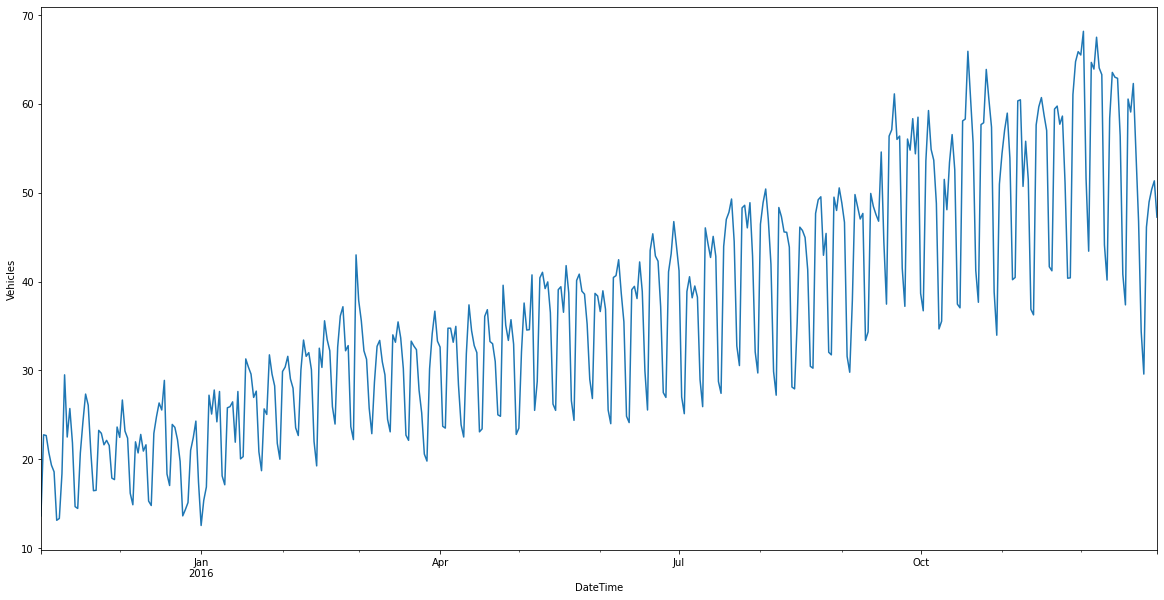

In [19]:
train_data_1.plot(figsize=(20,10))
plt.xlabel("DateTime")
plt.ylabel("Vehicles")
plt.show()

In [20]:
def print_adf_result(adf_result):
    df_results = pd.Series(adf_result[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
    
    for key, value in adf_result[4].items():
        df_results['Critical Value (%s)'% key] = value
    print('Augmented Dickey-Fuller Test Results:')
    print(df_results)
    

result_1 = adfuller(train_data_1, maxlag=7)
print_adf_result(result_1)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -1.543542
P-Value                   0.511872
# Lags Used               7.000000
# Observations Used     418.000000
Critical Value (1%)      -3.446091
Critical Value (5%)      -2.868479
Critical Value (10%)     -2.570466
dtype: float64


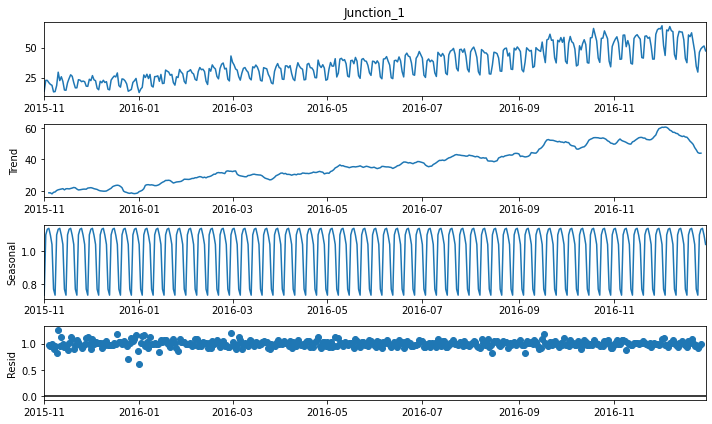

In [21]:
decomposition = sm.tsa.seasonal_decompose(train_data_1, model='multiplicative')
fig = decomposition.plot()
plt.show()

Text(0.5, 1.0, 'traffic junction 1')

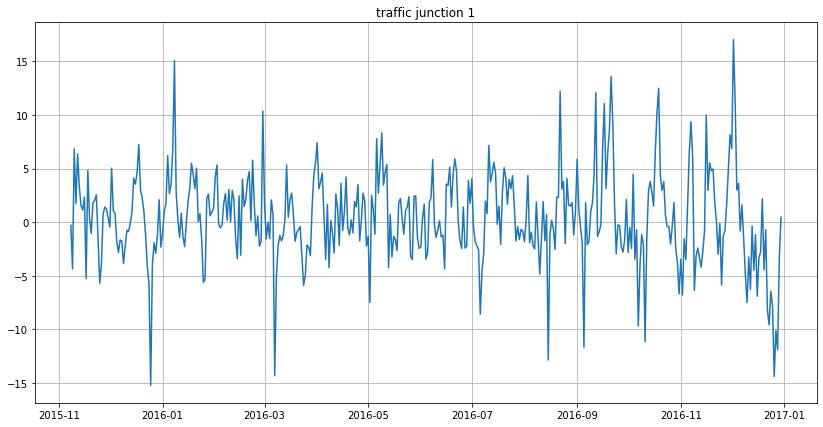

In [22]:
# seasonal differencing
traffic_season_diff_train_1 = train_data_1.diff(7)

# plot time plot
plt.figure(figsize=(14,7))
plt.grid()
plt.plot(traffic_season_diff_train_1)
plt.title('traffic junction 1')

In [23]:
print_adf_result(adfuller(traffic_season_diff_train_1.dropna()))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -4.293461
P-Value                   0.000456
# Lags Used              15.000000
# Observations Used     403.000000
Critical Value (1%)      -3.446681
Critical Value (5%)      -2.868739
Critical Value (10%)     -2.570605
dtype: float64


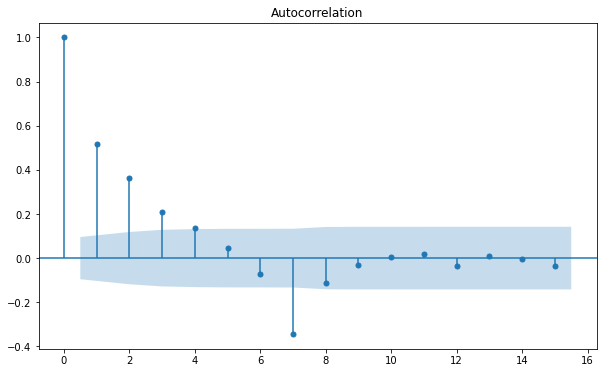

In [24]:
# plot ACF plot
plot_acf(traffic_season_diff_train_1.dropna(), lags=range(0,16));

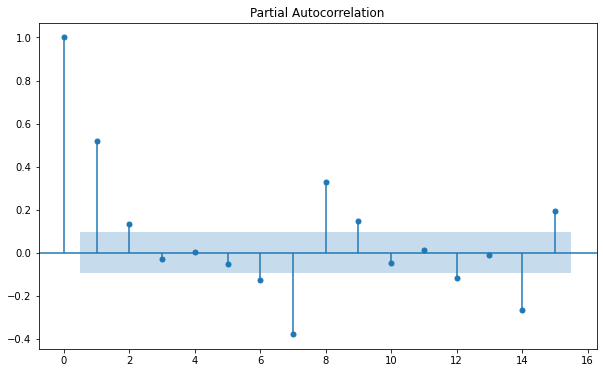

In [25]:
plot_pacf(traffic_season_diff_train_1.dropna(), lags=range(0,16));

In [26]:
# fitting ARIMA(0,0,0) model
arima_000_1 = ARIMA(traffic_season_diff_train_1.dropna(), order=(0,0,0)).fit()
arima_000_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             Junction_1   No. Observations:                  419
Model:                     ARMA(0, 0)   Log Likelihood               -1200.328
Method:                           css   S.D. of innovations              4.245
Date:                Sun, 04 Apr 2021   AIC                           2404.657
Time:                        13:31:00   BIC                           2412.733
Sample:                    11-08-2015   HQIC                          2407.849
                         - 12-30-2016                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4228      0.207      2.039      0.041       0.016       0.829
==============================================================================
"""

In [27]:
# fitting ARIMA(1,0,1) model
arima_100_1 = ARIMA(traffic_season_diff_train_1.dropna(), order=(1,0,0)).fit()
arima_100_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             Junction_1   No. Observations:                  419
Model:                     ARMA(1, 0)   Log Likelihood               -1135.720
Method:                       css-mle   S.D. of innovations              3.637
Date:                Sun, 04 Apr 2021   AIC                           2277.441
Time:                        13:31:18   BIC                           2289.555
Sample:                    11-08-2015   HQIC                          2282.229
                         - 12-30-2016                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.4211      0.365      1.154      0.249      -0.294       1.137
ar.L1.Junction_1     0.5145      0.042     12.316      0.000       0.433       0.596
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.9438           +0.0000j            1.9438            0.0000
-----------------------------------------------------------------------------
"""

In [87]:
residuals_1 = pd.Series(arima_100_1.resid)

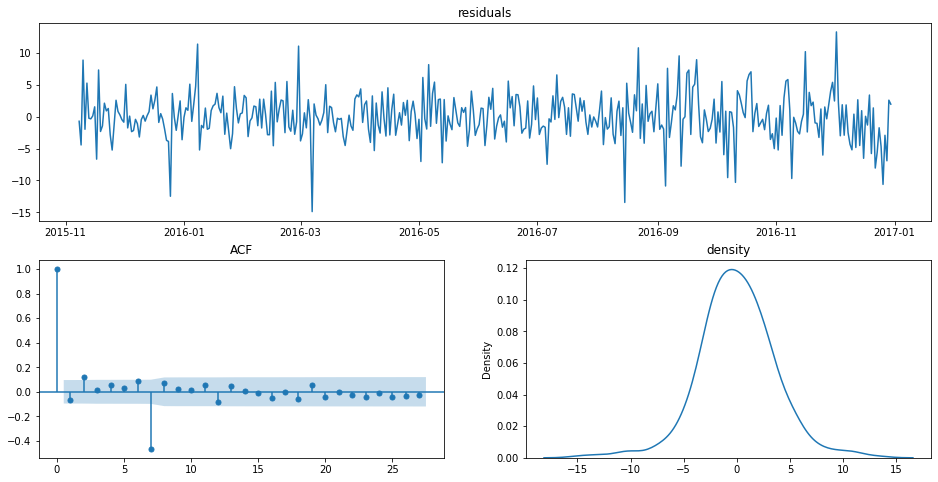

In [88]:
def check_residuals(series):
    fig = plt.figure(figsize=(16, 8))    
    gs = fig.add_gridspec(2,2)
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(series)
    ax1.set_title('residuals')
    
    ax2 = fig.add_subplot(gs[1,0])
    plot_acf(series, ax=ax2, title='ACF')
    
    ax3 = fig.add_subplot(gs[1,1])
    sns.kdeplot(series, ax=ax3)
    ax3.set_title('density')
    
    plt.show()
    
check_residuals(residuals_1)

In [89]:
arima_100_1.forecast(1)

(array([0.44026662]), array([3.6373108]), array([[-6.68873155,  7.5692648 ]]))

In [90]:
arima_forecast_1, se_1, conf_1 = arima_100_1.forecast(182)

arima_forecast_1 = pd.Series(arima_forecast_1, index=test_data_1.index)
lower_series_1 = pd.Series(conf_1[:, 0], index=test_data_1.index)
upper_series_1 = pd.Series(conf_1[:, 1], index=test_data_1.index)

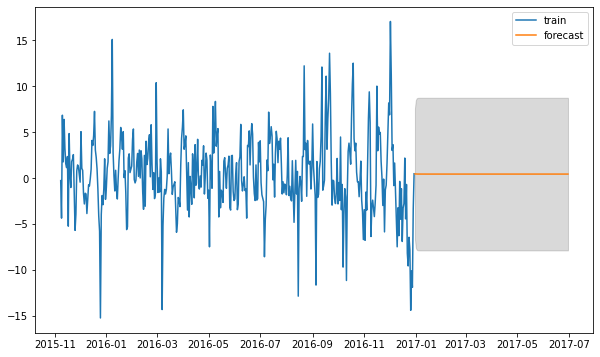

In [91]:
plt.plot(traffic_season_diff_train_1, label='train')
plt.plot(arima_forecast_1, label='forecast')

plt.fill_between(lower_series_1.index, lower_series_1, upper_series_1, color='k', alpha=.15)
plt.legend()

In [92]:
def inverse_differencing(orig_data, diff_data, interval):
    output = orig_data[:interval].tolist()
    for i in range(interval, len(diff_data)):
        output.append(output[i-interval] + diff_data[i])
    return output

def inverse_differencing_forecast(orig_series, diff_series, forecast_series, interval):
    series_merge = diff_series.append(forecast_series)
    inverse_diff_series = pd.Series(inverse_differencing(orig_series, series_merge, interval), 
                                    index=series_merge.index)
    return inverse_diff_series[-len(forecast_series):]

def train_test_forecast_plot(train_series, test_series, forecast_series, lower_upper=None):
    plt.plot(train_series, label = 'train')
    plt.plot(test_series, label = 'test')
    plt.plot(forecast_series, label = 'forecast')

    if lower_upper is not None:
        plt.fill_between(lower_upper[0].index, lower_upper[0], 
                     lower_upper[1], color='k', alpha=.15)
    plt.legend()

In [93]:
# inverse differenced series back to original series
traffic_forecast_series_1 = inverse_differencing_forecast(train_data_1, traffic_season_diff_train_1, arima_forecast_1, 7)
traffic_lower_series_1 = inverse_differencing_forecast(train_data_1, traffic_season_diff_train_1, lower_series_1, 7)
traffic_upper_series_1 = inverse_differencing_forecast(train_data_1, traffic_season_diff_train_1, upper_series_1, 7)

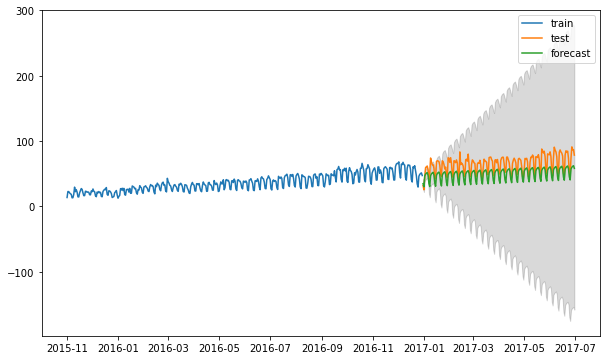

In [94]:
train_test_forecast_plot(train_data_1, test_data_1, traffic_forecast_series_1, 
                         [traffic_lower_series_1, traffic_upper_series_1])

In [95]:
from sklearn.metrics import mean_squared_error

mse_1 = mean_squared_error(test_data_1, traffic_forecast_series_1)
print('Test MSE: ', mse_1)

Test MSE:  271.2102986966659


In [96]:
param_p = [0,1,2,3,4,5]
param_d = [0,1,2] # ARIMA only support two times of differencing
param_q = [0,1,2,3,4,5]

In [97]:
best_error, best_params, best_model = None, None, None

for p in param_p:
    for d in param_d:
        for q in param_q:
            try:
                arima = ARIMA(traffic_season_diff_train_1.dropna(), order=(p,d,q)).fit()
                if best_error is None or arima.aic < best_error:
                    best_error = arima.aic
                    best_params = (p,d,q)
                    best_model = arima
                #print('ARIMA({},{},{}), AIC={}'.format(p,d,q, arima.aic))
            except:
                pass
print('Best Error={}, Best Params={}'.format(best_error, best_params))

Best Error=2152.9849374489118, Best Params=(4, 0, 5)


In [98]:
arima_forecast_1, se_1, conf_1 = best_model.forecast(182)

arima_forecast_1 = pd.Series(arima_forecast_1, index=test_data_1.index)
lower_series_1 = pd.Series(conf_1[:, 0], index=test_data_1.index)
upper_series_1 = pd.Series(conf_1[:, 1], index=test_data_1.index)

In [99]:
traffic_forecast_series_1 = inverse_differencing_forecast(train_data_1, traffic_season_diff_train_1, arima_forecast_1, 7)
traffic_lower_series_1 = inverse_differencing_forecast(train_data_1, traffic_season_diff_train_1, lower_series_1, 7)
traffic_upper_series_1 = inverse_differencing_forecast(train_data_1, traffic_season_diff_train_1, upper_series_1, 7)

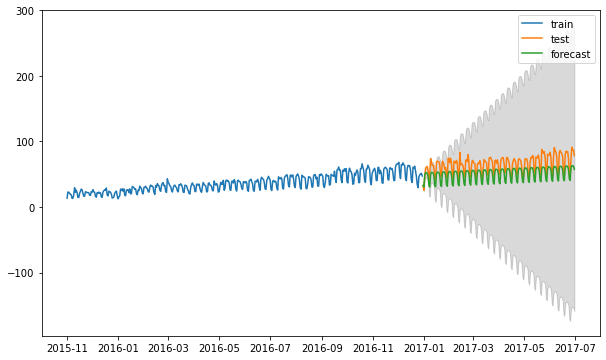

In [100]:
train_test_forecast_plot(train_data_1, test_data_1, traffic_forecast_series_1, 
                         [traffic_lower_series_1, traffic_upper_series_1])

In [101]:
mse_1 = mean_squared_error(test_data_1, traffic_forecast_series_1)
print('Test MSE 1: ', mse_1)

Test MSE 1:  243.63648363405832


In [102]:
import math
RMSE_1 = math.sqrt(mse_1)
print("Root Mean Square Error 1:\n")
print(RMSE_1)

Root Mean Square Error 1:

15.608859139413692


# Junction 2 

In [103]:
traffic_2 = traffic_merge['Junction_2']
traffic_2

DateTime
2015-11-01 00:00:00     6.0
2015-11-01 01:00:00     6.0
2015-11-01 02:00:00     5.0
2015-11-01 03:00:00     6.0
2015-11-01 04:00:00     7.0
                       ... 
2017-06-30 19:00:00    34.0
2017-06-30 20:00:00    35.0
2017-06-30 21:00:00    31.0
2017-06-30 22:00:00    29.0
2017-06-30 23:00:00    27.0
Name: Junction_2, Length: 14592, dtype: float64

In [104]:
traffic_2_resample = traffic_merge['Junction_2'].resample('D').mean()
traffic_2_resample

DateTime
2015-11-01     5.541667
2015-11-02     8.208333
2015-11-03     9.041667
2015-11-04     8.291667
2015-11-05     8.333333
                ...    
2017-06-26    24.458333
2017-06-27    30.416667
2017-06-28    30.000000
2017-06-29    29.000000
2017-06-30    27.291667
Freq: D, Name: Junction_2, Length: 608, dtype: float64

In [105]:
train_data_2 = traffic_2_resample[:-split_data]
test_data_2 = traffic_2_resample[-split_data:]
train_time_2 = traffic_2_resample.index[:-split_data]
test_time_2 = traffic_2_resample.index[-split_data:]

print("train_data_shape")
print(train_data_2.shape)
print("test_data_shape")
print(test_data_2.shape)

train_data_shape
(426,)
test_data_shape
(182,)


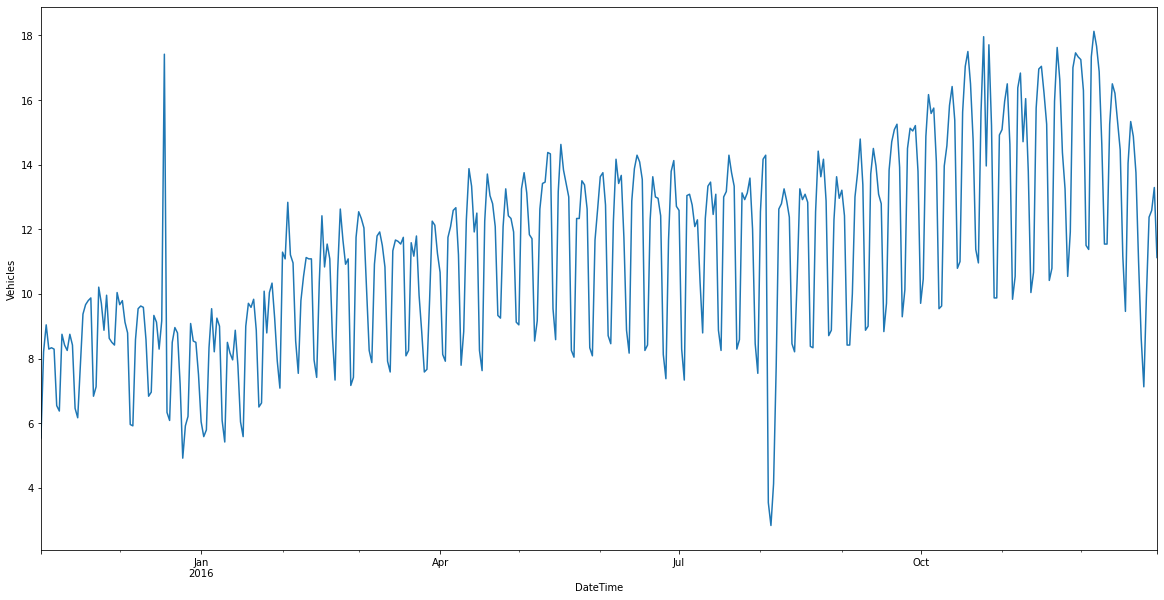

In [106]:
train_data_2.plot(figsize=(20,10))
plt.xlabel("DateTime")
plt.ylabel("Vehicles")
plt.show()

In [107]:
result_2 = adfuller(train_data_2, maxlag=7)
print_adf_result(result_2)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -2.055811
P-Value                   0.262650
# Lags Used               7.000000
# Observations Used     418.000000
Critical Value (1%)      -3.446091
Critical Value (5%)      -2.868479
Critical Value (10%)     -2.570466
dtype: float64


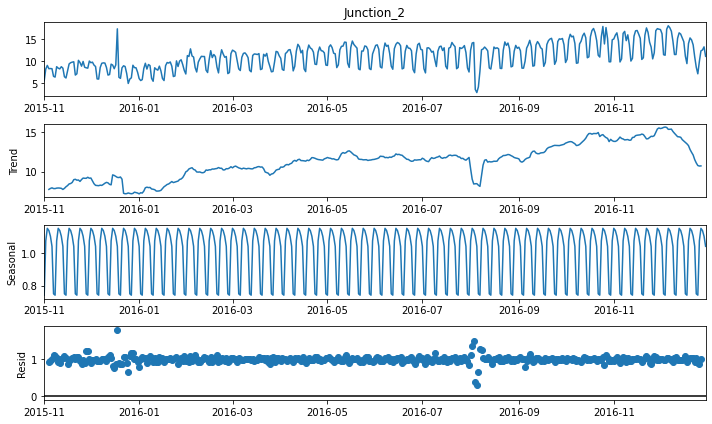

In [108]:
decomposition = sm.tsa.seasonal_decompose(train_data_2, model='multiplicative')
fig = decomposition.plot()
plt.show()

Text(0.5, 1.0, 'traffic junction 2')

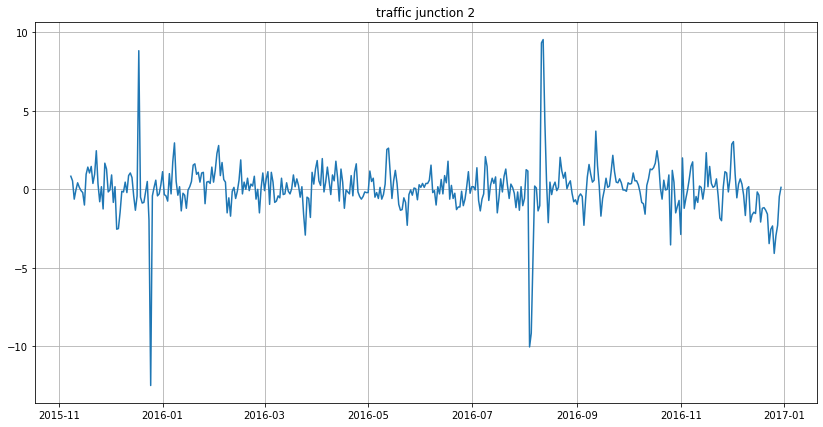

In [109]:
# seasonal differencing
traffic_season_diff_train_2 = train_data_2.diff(7)

# plot time plot
plt.figure(figsize=(14,7))
plt.grid()
plt.plot(traffic_season_diff_train_2)
plt.title('traffic junction 2')

In [110]:
print_adf_result(adfuller(traffic_season_diff_train_2.dropna()))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -5.237237
P-Value                   0.000007
# Lags Used              14.000000
# Observations Used     404.000000
Critical Value (1%)      -3.446640
Critical Value (5%)      -2.868721
Critical Value (10%)     -2.570595
dtype: float64


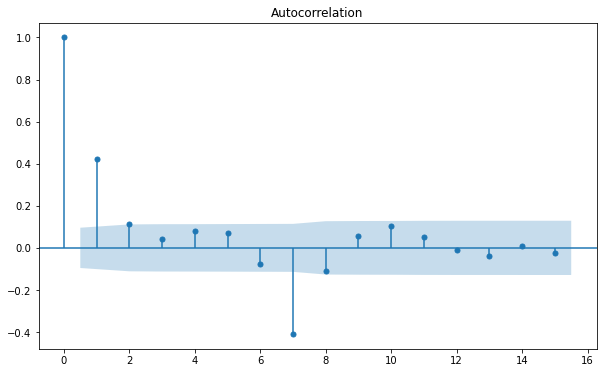

In [111]:
# plot ACF plot
plot_acf(traffic_season_diff_train_2.dropna(), lags=range(0,16));

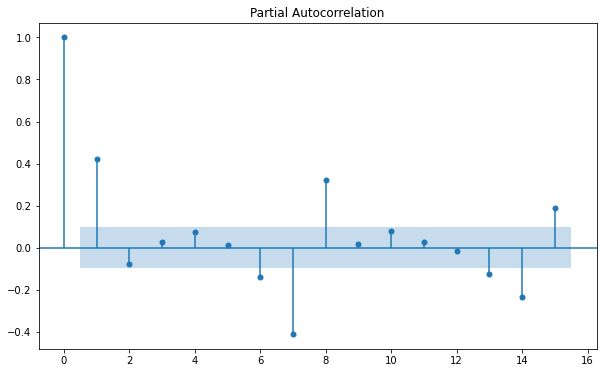

In [112]:
plot_pacf(traffic_season_diff_train_2.dropna(), lags=range(0,16));

In [113]:
param_p = [0,1,2,3,4,5]
param_d = [0,1,2] # ARIMA only support two times of differencing
param_q = [0,1,2,3,4,5]

In [114]:
best_error, best_params, best_model = None, None, None

for p in param_p:
    for d in param_d:
        for q in param_q:
            try:
                arima = ARIMA(traffic_season_diff_train_2.dropna(), order=(p,d,q)).fit()
                if best_error is None or arima.aic < best_error:
                    best_error = arima.aic
                    best_params = (p,d,q)
                    best_model = arima
                #print('ARIMA({},{},{}), AIC={}'.format(p,d,q, arima.aic))
            except:
                pass
print('Best Error={}, Best Params={}'.format(best_error, best_params))

Best Error=1397.5580804960828, Best Params=(4, 0, 5)


In [115]:
arima_forecast_2, se_2, conf_2 = best_model.forecast(182)

arima_forecast_2 = pd.Series(arima_forecast_2, index=test_data_2.index)
lower_series_2 = pd.Series(conf_2[:, 0], index=test_data_2.index)
upper_series_2 = pd.Series(conf_2[:, 1], index=test_data_2.index)

In [116]:
traffic_forecast_series_2 = inverse_differencing_forecast(train_data_2, traffic_season_diff_train_2, arima_forecast_2, 7)
traffic_lower_series_2 = inverse_differencing_forecast(train_data_2, traffic_season_diff_train_2, lower_series_2, 7)
traffic_upper_series_2 = inverse_differencing_forecast(train_data_2, traffic_season_diff_train_2, upper_series_2, 7)

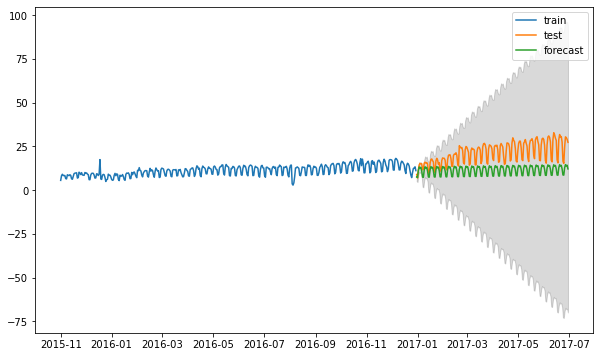

In [117]:
train_test_forecast_plot(train_data_2, test_data_2, traffic_forecast_series_2, 
                         [traffic_lower_series_2, traffic_upper_series_2])

In [118]:
mse_2 = mean_squared_error(test_data_2, traffic_forecast_series_2)
print('Test MSE 2: ', mse_2)

Test MSE 2:  115.60169792534097


In [119]:
import math
RMSE_2 = math.sqrt(mse_2)
print("Root Mean Square Error 2:\n")
print(RMSE_2)

Root Mean Square Error 2:

10.751823004743938


# Junction 3

In [121]:
traffic_3 = traffic_merge['Junction_3']
traffic_3

DateTime
2015-11-01 00:00:00     9.0
2015-11-01 01:00:00     7.0
2015-11-01 02:00:00     5.0
2015-11-01 03:00:00     1.0
2015-11-01 04:00:00     2.0
                       ... 
2017-06-30 19:00:00    33.0
2017-06-30 20:00:00    31.0
2017-06-30 21:00:00    28.0
2017-06-30 22:00:00    26.0
2017-06-30 23:00:00    39.0
Name: Junction_3, Length: 14592, dtype: float64

In [122]:
traffic_3_resample = traffic_merge['Junction_3'].resample('D').mean()
traffic_3_resample

DateTime
2015-11-01     5.666667
2015-11-02     6.916667
2015-11-03     6.250000
2015-11-04     5.041667
2015-11-05     4.416667
                ...    
2017-06-26    17.250000
2017-06-27    23.625000
2017-06-28    20.958333
2017-06-29    20.708333
2017-06-30    23.041667
Freq: D, Name: Junction_3, Length: 608, dtype: float64

In [123]:
train_data_3 = traffic_3_resample[:-split_data]
test_data_3 = traffic_3_resample[-split_data:]
train_time_3 = traffic_3_resample.index[:-split_data]
test_time_3 = traffic_3_resample.index[-split_data:]

print("train_data_shape")
print(train_data_3.shape)
print("test_data_shape")
print(test_data_3.shape)

train_data_shape
(426,)
test_data_shape
(182,)


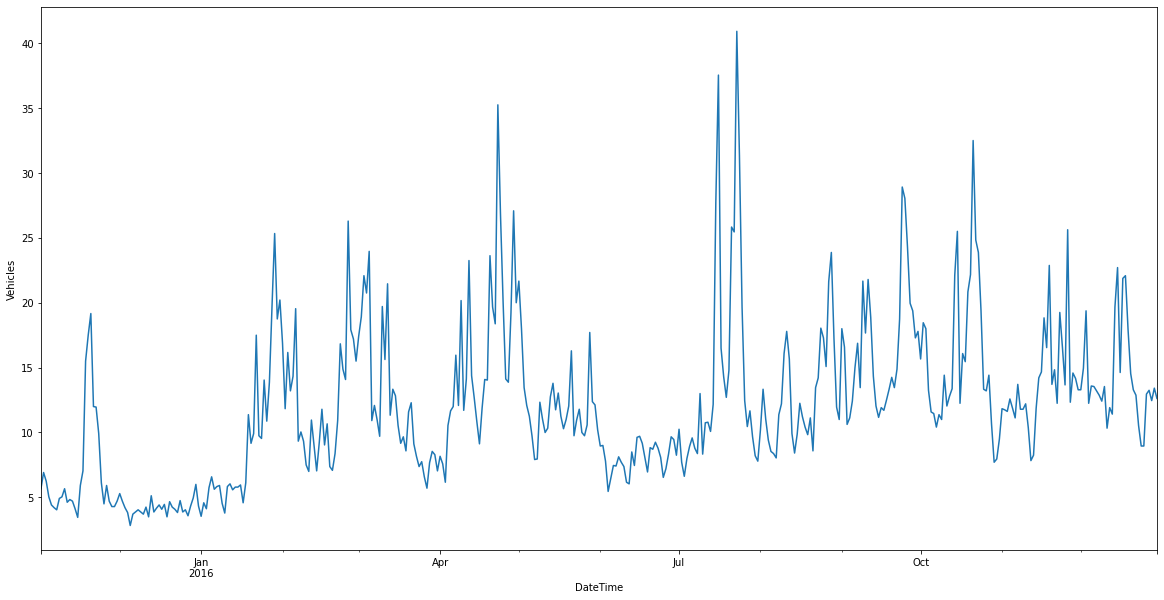

In [124]:
train_data_3.plot(figsize=(20,10))
plt.xlabel("DateTime")
plt.ylabel("Vehicles")
plt.show()

In [125]:
result_3 = adfuller(train_data_3, maxlag=7)
print_adf_result(result_3)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -3.930754
P-Value                   0.001820
# Lags Used               6.000000
# Observations Used     419.000000
Critical Value (1%)      -3.446054
Critical Value (5%)      -2.868463
Critical Value (10%)     -2.570458
dtype: float64


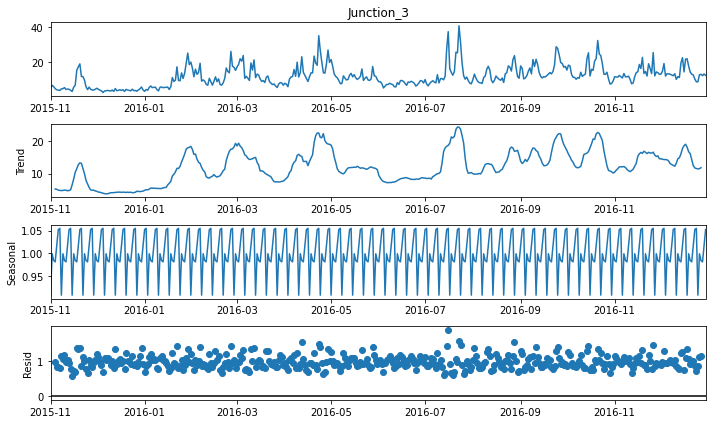

In [126]:
decomposition = sm.tsa.seasonal_decompose(train_data_3, model='multiplicative')
fig = decomposition.plot()
plt.show()

Text(0.5, 1.0, 'traffic junction 3')

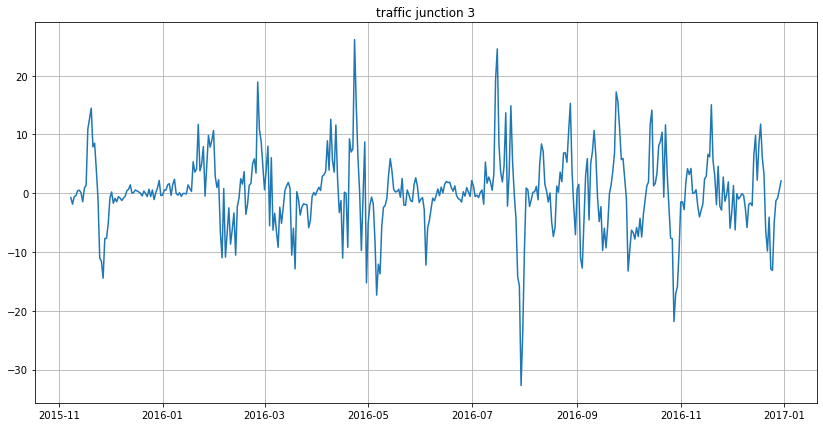

In [127]:
# seasonal differencing
traffic_season_diff_train_3 = train_data_3.diff(7)

# plot time plot
plt.figure(figsize=(14,7))
plt.grid()
plt.plot(traffic_season_diff_train_3)
plt.title('traffic junction 3')

In [128]:
print_adf_result(adfuller(traffic_season_diff_train_3.dropna()))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -6.269112e+00
P-Value                 4.045115e-08
# Lags Used             1.800000e+01
# Observations Used     4.000000e+02
Critical Value (1%)    -3.446804e+00
Critical Value (5%)    -2.868793e+00
Critical Value (10%)   -2.570634e+00
dtype: float64


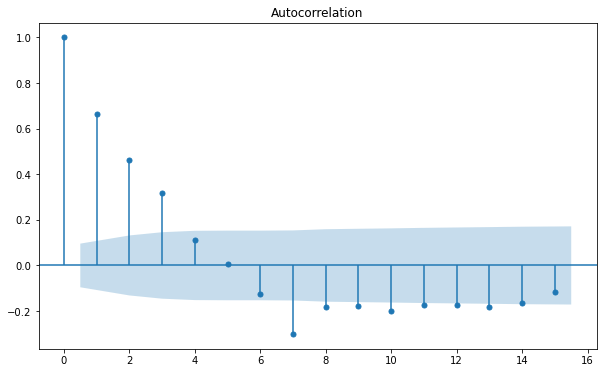

In [129]:
# plot ACF plot
plot_acf(traffic_season_diff_train_3.dropna(), lags=range(0,16));

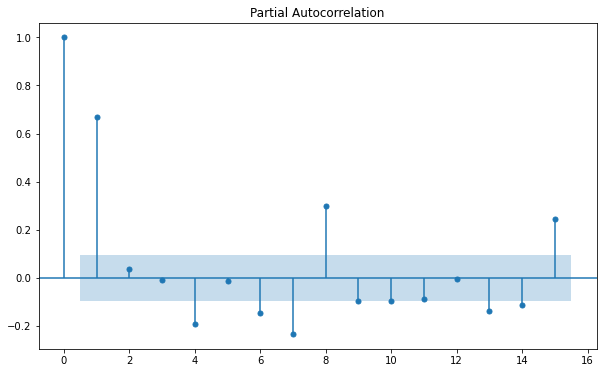

In [130]:
plot_pacf(traffic_season_diff_train_3.dropna(), lags=range(0,16));

In [131]:
param_p = [0,1,2,3,4,5]
param_d = [0,1,2] # ARIMA only support two times of differencing
param_q = [0,1,2,3,4,5]

In [132]:
best_error, best_params, best_model = None, None, None

for p in param_p:
    for d in param_d:
        for q in param_q:
            try:
                arima = ARIMA(traffic_season_diff_train_3.dropna(), order=(p,d,q)).fit()
                if best_error is None or arima.aic < best_error:
                    best_error = arima.aic
                    best_params = (p,d,q)
                    best_model = arima
                #print('ARIMA({},{},{}), AIC={}'.format(p,d,q, arima.aic))
            except:
                pass
print('Best Error={}, Best Params={}'.format(best_error, best_params))

Best Error=2388.682918729439, Best Params=(4, 0, 5)


In [133]:
arima_forecast_3, se_3, conf_3 = best_model.forecast(182)

arima_forecast_3 = pd.Series(arima_forecast_3, index=test_data_3.index)
lower_series_3 = pd.Series(conf_3[:, 0], index=test_data_3.index)
upper_series_3 = pd.Series(conf_3[:, 1], index=test_data_3.index)

In [134]:
traffic_forecast_series_3 = inverse_differencing_forecast(train_data_3, traffic_season_diff_train_3, arima_forecast_3, 7)
traffic_lower_series_3 = inverse_differencing_forecast(train_data_3, traffic_season_diff_train_3, lower_series_3, 7)
traffic_upper_series_3 = inverse_differencing_forecast(train_data_3, traffic_season_diff_train_3, upper_series_3, 7)

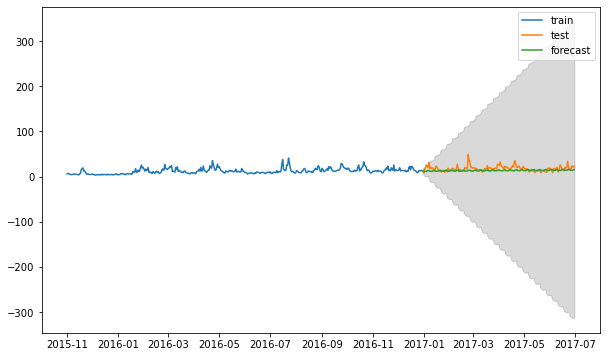

In [135]:
train_test_forecast_plot(train_data_3, test_data_3, traffic_forecast_series_3, 
                         [traffic_lower_series_3, traffic_upper_series_3])

In [136]:
mse_3 = mean_squared_error(test_data_3, traffic_forecast_series_3)
print('Test MSE 3: ', mse_3)

Test MSE 3:  50.43330075166865


In [137]:
import math
RMSE_3 = math.sqrt(mse_3)
print("Root Mean Square Error 3:\n")
print(RMSE_3)

Root Mean Square Error 3:

7.1016407084327104


# Junction 4

In [138]:
traffic_4 = traffic_merge['Junction_4']
traffic_4 

DateTime
2015-11-01 00:00:00     0.0
2015-11-01 01:00:00     0.0
2015-11-01 02:00:00     0.0
2015-11-01 03:00:00     0.0
2015-11-01 04:00:00     0.0
                       ... 
2017-06-30 19:00:00    11.0
2017-06-30 20:00:00    30.0
2017-06-30 21:00:00    16.0
2017-06-30 22:00:00    22.0
2017-06-30 23:00:00    12.0
Name: Junction_4, Length: 14592, dtype: float64

In [139]:
traffic_4_resample = traffic_merge['Junction_4'].resample('D').mean()
traffic_4_resample

DateTime
2015-11-01     0.000000
2015-11-02     0.000000
2015-11-03     0.000000
2015-11-04     0.000000
2015-11-05     0.000000
                ...    
2017-06-26     7.541667
2017-06-27     9.375000
2017-06-28    11.500000
2017-06-29    12.333333
2017-06-30    11.333333
Freq: D, Name: Junction_4, Length: 608, dtype: float64

In [140]:
traffic4 = traffic_4_resample[traffic_4_resample .values != 0] 
traffic4

DateTime
2017-01-01     3.875000
2017-01-02     7.583333
2017-01-03     9.541667
2017-01-04     8.000000
2017-01-05     9.750000
                ...    
2017-06-26     7.541667
2017-06-27     9.375000
2017-06-28    11.500000
2017-06-29    12.333333
2017-06-30    11.333333
Freq: D, Name: Junction_4, Length: 181, dtype: float64

In [141]:
split_data_4 = round(len(traffic4)*0.3)
split_data_4

54

In [142]:
train_data_4 = traffic4[:-split_data_4]
test_data_4 = traffic4[-split_data_4:]
train_time_4 = traffic4.index[:-split_data_4]
test_time_4 = traffic4.index[-split_data_4:]

print("train_data_shape")
print(train_data_4.shape)
print("test_data_shape")
print(test_data_4.shape)

train_data_shape
(127,)
test_data_shape
(54,)


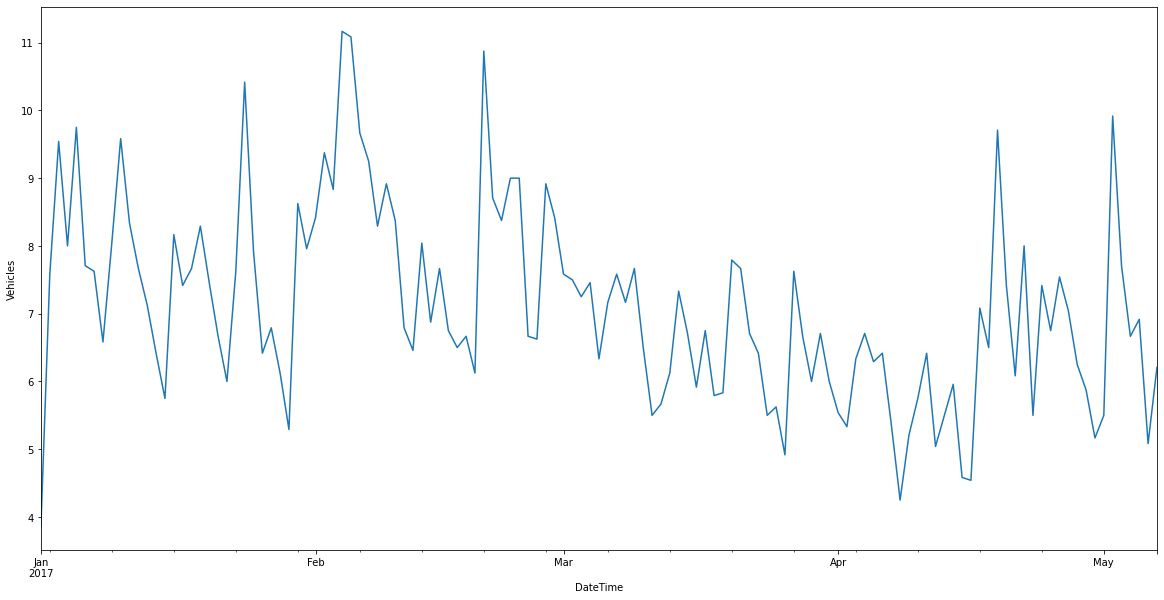

In [143]:
train_data_4.plot(figsize=(20,10))
plt.xlabel("DateTime")
plt.ylabel("Vehicles")
plt.show()

In [144]:
result_4 = adfuller(train_data_4, maxlag=7)
print_adf_result(result_4)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -2.024024
P-Value                   0.276140
# Lags Used               6.000000
# Observations Used     120.000000
Critical Value (1%)      -3.486056
Critical Value (5%)      -2.885943
Critical Value (10%)     -2.579785
dtype: float64


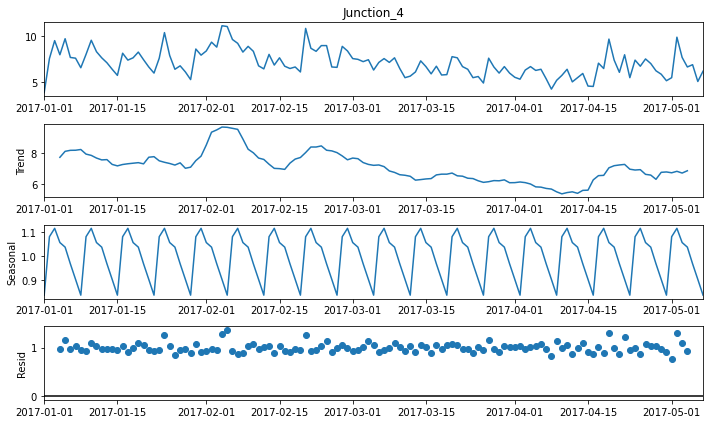

In [145]:
decomposition = sm.tsa.seasonal_decompose(train_data_4, model='multiplicative')
fig = decomposition.plot()
plt.show()

Text(0.5, 1.0, 'traffic junction 4')

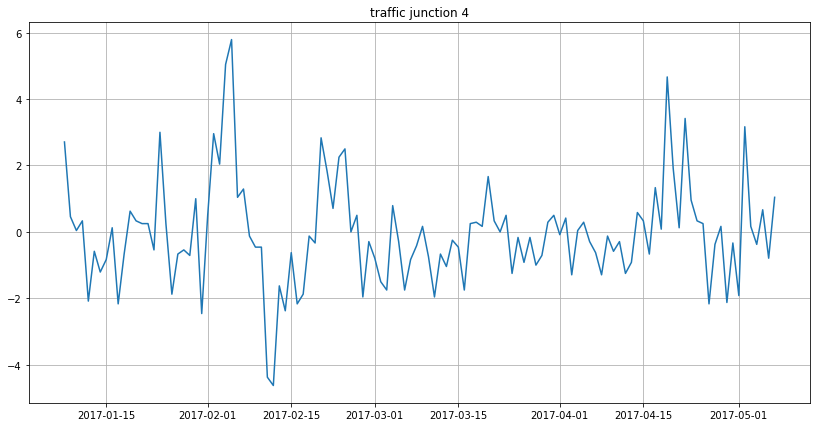

In [146]:
# seasonal differencing
traffic_season_diff_train_4 = train_data_4.diff(7)

# plot time plot
plt.figure(figsize=(14,7))
plt.grid()
plt.plot(traffic_season_diff_train_4)
plt.title('traffic junction 4')

In [147]:
print_adf_result(adfuller(traffic_season_diff_train_4.dropna()))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -7.219247e+00
P-Value                 2.132690e-10
# Lags Used             6.000000e+00
# Observations Used     1.130000e+02
Critical Value (1%)    -3.489590e+00
Critical Value (5%)    -2.887477e+00
Critical Value (10%)   -2.580604e+00
dtype: float64


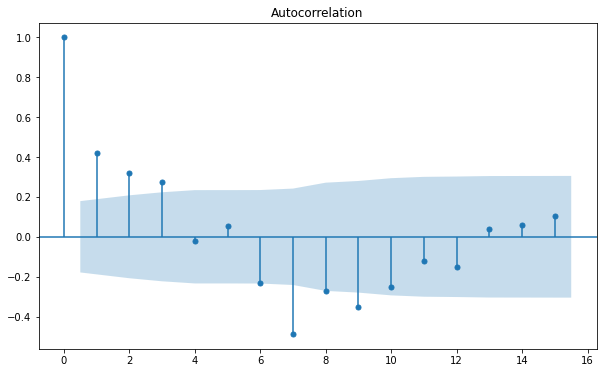

In [148]:
# plot ACF plot
plot_acf(traffic_season_diff_train_4.dropna(), lags=range(0,16));

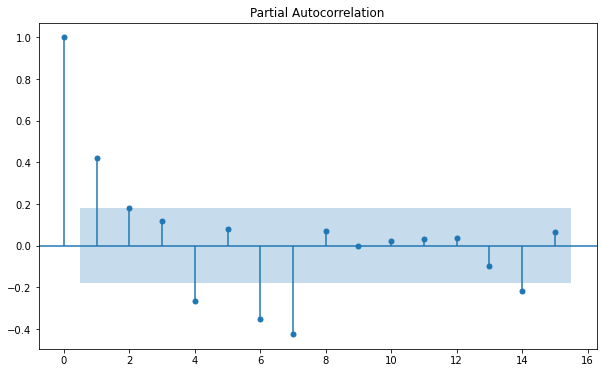

In [149]:
plot_pacf(traffic_season_diff_train_4.dropna(), lags=range(0,16));

In [150]:
param_p = [0,1,2,3,4,5]
param_d = [0,1,2] # ARIMA only support two times of differencing
param_q = [0,1,2,3,4,5]

In [151]:
best_error, best_params, best_model = None, None, None

for p in param_p:
    for d in param_d:
        for q in param_q:
            try:
                arima = ARIMA(traffic_season_diff_train_4.dropna(), order=(p,d,q)).fit()
                if best_error is None or arima.aic < best_error:
                    best_error = arima.aic
                    best_params = (p,d,q)
                    best_model = arima
                #print('ARIMA({},{},{}), AIC={}'.format(p,d,q, arima.aic))
            except:
                pass
print('Best Error={}, Best Params={}'.format(best_error, best_params))

Best Error=399.5834135327425, Best Params=(3, 0, 5)


In [152]:
arima_forecast_4, se_4, conf_4 = best_model.forecast(54)

arima_forecast_4 = pd.Series(arima_forecast_4, index=test_data_4.index)
lower_series_4 = pd.Series(conf_4[:, 0], index=test_data_4.index)
upper_series_4 = pd.Series(conf_4[:, 1], index=test_data_4.index)

In [153]:
traffic_forecast_series_4 = inverse_differencing_forecast(train_data_4, traffic_season_diff_train_4, arima_forecast_4, 7)
traffic_lower_series_4 = inverse_differencing_forecast(train_data_4, traffic_season_diff_train_4, lower_series_4, 7)
traffic_upper_series_4 = inverse_differencing_forecast(train_data_4, traffic_season_diff_train_4, upper_series_4, 7)

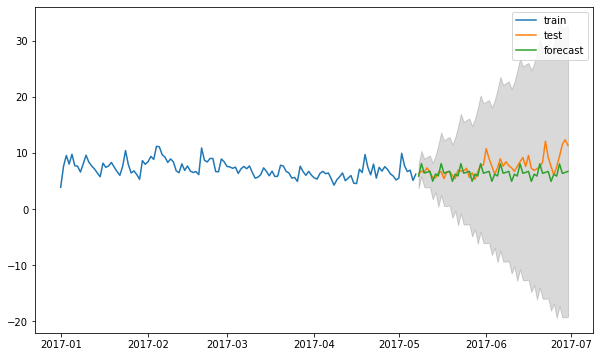

In [154]:
train_test_forecast_plot(train_data_4, test_data_4, traffic_forecast_series_4, 
                         [traffic_lower_series_4, traffic_upper_series_4])

In [155]:
mse_4 = mean_squared_error(test_data_4, traffic_forecast_series_4)
print('Test MSE 4: ', mse_4)

Test MSE 4:  4.206299287825478


In [156]:
import math
RMSE_4 = math.sqrt(mse_4)
print("Root Mean Square Error 4:\n")
print(RMSE_4)

Root Mean Square Error 4:

2.0509264462250902


# SARIMA

## Junction 1

In [174]:
sarimax = SARIMAX(traffic_season_diff_train_1, order=(3,1,2), seasonal_order=(4,1,0,7)).fit()
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         Junction_1   No. Observations:                  426
Model:             SARIMAX(3, 1, 2)x(4, 1, [], 7)   Log Likelihood               -1149.811
Date:                            Sun, 04 Apr 2021   AIC                           2319.622
Time:                                    19:14:52   BIC                           2359.977
Sample:                                11-01-2015   HQIC                          2335.575
                                     - 12-30-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4812      0.062     -7.734      0.000      -0.603      -0.359
ar.L2          0.7183      0.056     12.874      0.000       0.609       0.828
ar.L3          0.2101      0.055      3.791      0.000       0.101       0.319
ma.L1         -0.0017    171.472  -1.01e-05      1.000    -336.081     336.078
ma.L2         -0.9983    171.177     -0.006      0.995    -336.499     334.503
ar.S.L7       -1.4033      0.039    -35.562      0.000      -1.481      -1.326
ar.S.L14      -1.2784      0.064    -19.912      0.000      -1.404      -1.153
ar.S.L21      -0.8455      0.076    -11.067      0.000      -0.995      -0.696
ar.S.L28      -0.3466      0.049     -7.046      0.000      -0.443      -0.250
sigma2        11.4617   1965.213      0.006      0.995   -3840.284    3863.208
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                83.07
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.58   Skew:                            -0.45
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

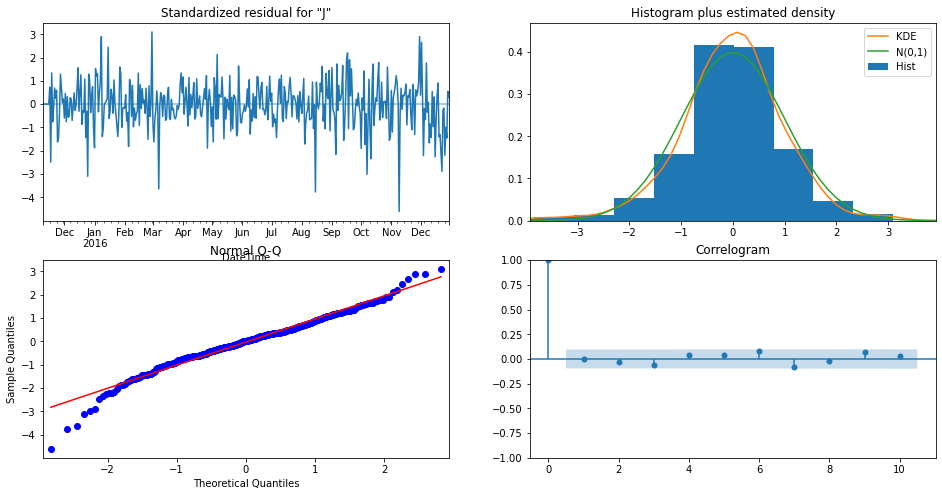

In [175]:
sarimax.plot_diagnostics(figsize=(16, 8))
plt.show()

In [201]:
sarimax_forecast = sarimax.get_forecast(182)
sarimax_forecast_conf_int = sarimax_forecast.conf_int()

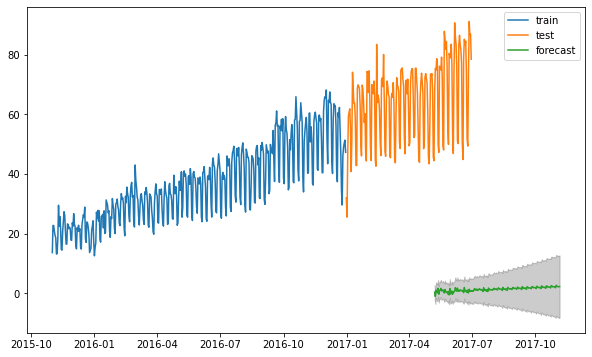

In [202]:
plt.plot(train_data_1, label='train')
plt.plot(test_data_1, label='test')
plt.plot(sarimax_forecast.predicted_mean, label='forecast')


plt.fill_between(sarimax_forecast_conf_int.index,
                 sarimax_forecast_conf_int.iloc[:, 0],
                 sarimax_forecast_conf_int.iloc[:, 1], color='k', alpha=.2)
                 

plt.legend()

In [203]:
s_mse1 = mean_squared_error(test_data_1, sarimax_forecast.predicted_mean)
print('Test MSE: ',s_mse1)

Test MSE:  4194.632491123947


In [204]:
s_rmse1 = np.sqrt(s_mse1)
print('Test RMSE: ',s_rmse1)

Test RMSE:  64.7659825149279


In [205]:
from sklearn.metrics import mean_absolute_error
s_mae1 = mean_absolute_error(test_data_1, sarimax_forecast.predicted_mean)
print('Test MAE: ', s_mae1)

Test MAE:  63.41281847790632


## Junction 2

In [206]:
sarimax = SARIMAX(traffic_season_diff_train_2, order=(3,1,2), seasonal_order=(4,1,0,7)).fit()
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         Junction_2   No. Observations:                  426
Model:             SARIMAX(3, 1, 2)x(4, 1, [], 7)   Log Likelihood                -790.182
Date:                            Sun, 04 Apr 2021   AIC                           1600.365
Time:                                    20:06:09   BIC                           1640.719
Sample:                                11-01-2015   HQIC                          1616.318
                                     - 12-30-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4683      0.034    -13.730      0.000      -0.535      -0.401
ar.L2          0.5007      0.066      7.615      0.000       0.372       0.630
ar.L3         -0.0254      0.062     -0.409      0.682      -0.147       0.096
ma.L1         -0.0089      4.817     -0.002      0.999      -9.450       9.432
ma.L2         -0.9911      4.771     -0.208      0.835     -10.341       8.359
ar.S.L7       -1.3403      0.023    -59.156      0.000      -1.385      -1.296
ar.S.L14      -1.1850      0.042    -28.235      0.000      -1.267      -1.103
ar.S.L21      -0.7855      0.056    -14.144      0.000      -0.894      -0.677
ar.S.L28      -0.3316      0.031    -10.614      0.000      -0.393      -0.270
sigma2         1.9943      9.580      0.208      0.835     -16.783      20.771
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3557.51
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                            -0.67
Prob(H) (two-sided):                  0.03   Kurtosis:                        17.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

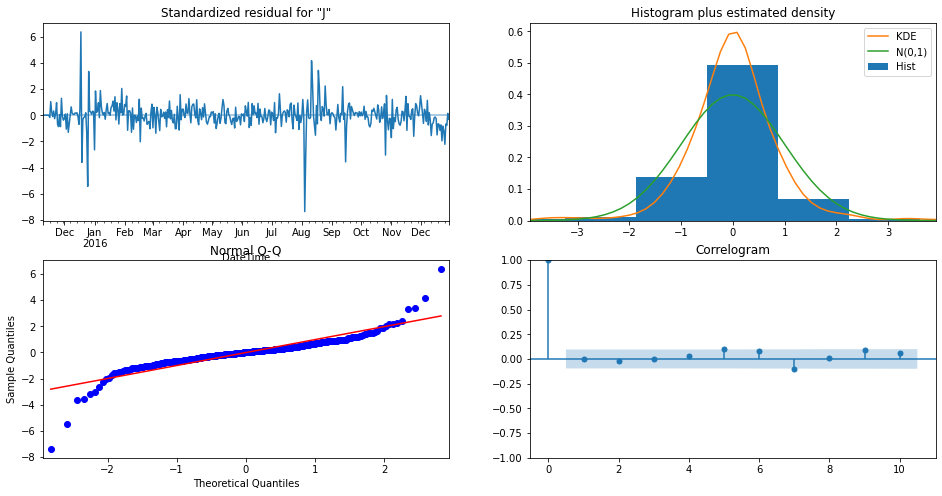

In [207]:
sarimax.plot_diagnostics(figsize=(16, 8))
plt.show()

In [209]:
sarimax_forecast = sarimax.get_forecast(182)
sarimax_forecast_conf_int = sarimax_forecast.conf_int()

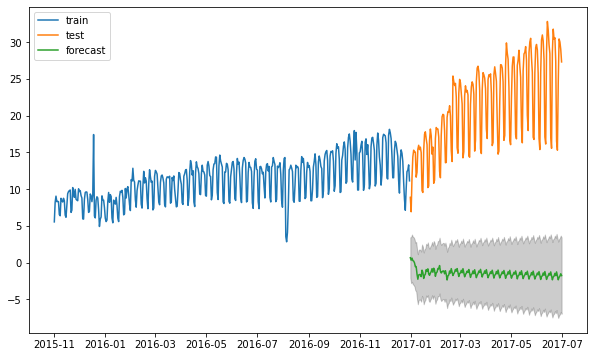

In [210]:
plt.plot(train_data_2, label='train')
plt.plot(test_data_2, label='test')
plt.plot(sarimax_forecast.predicted_mean, label='forecast')


plt.fill_between(sarimax_forecast_conf_int.index,
                 sarimax_forecast_conf_int.iloc[:, 0],
                 sarimax_forecast_conf_int.iloc[:, 1], color='k', alpha=.2)
                 

plt.legend()

In [211]:
s_mse2 = mean_squared_error(test_data_2, sarimax_forecast.predicted_mean)
print('Test MSE: ',s_mse2)

Test MSE:  555.275368478739


In [212]:
s_rmse2 = np.sqrt(s_mse2)
print('Test RMSE: ',s_rmse2)

Test RMSE:  23.564281624499802


In [213]:
s_mae2 = mean_absolute_error(test_data_2, sarimax_forecast.predicted_mean)
print('Test MAE: ', s_mae2)

Test MAE:  22.715877095566842


## Junction 3

In [214]:
sarimax = SARIMAX(traffic_season_diff_train_3, order=(3,1,2), seasonal_order=(4,1,0,7)).fit()
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         Junction_3   No. Observations:                  426
Model:             SARIMAX(3, 1, 2)x(4, 1, [], 7)   Log Likelihood               -1306.585
Date:                            Sun, 04 Apr 2021   AIC                           2633.171
Time:                                    20:08:14   BIC                           2673.526
Sample:                                11-01-2015   HQIC                          2649.124
                                     - 12-30-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.8693      0.042    -44.361      0.000      -1.952      -1.787
ar.L2         -1.2609      0.065    -19.268      0.000      -1.389      -1.133
ar.L3         -0.2527      0.039     -6.486      0.000      -0.329      -0.176
ma.L1          1.8016      0.905      1.991      0.047       0.028       3.576
ma.L2          0.9997      1.004      0.995      0.320      -0.969       2.968
ar.S.L7       -1.1401      0.044    -25.837      0.000      -1.227      -1.054
ar.S.L14      -0.9794      0.066    -14.785      0.000      -1.109      -0.850
ar.S.L21      -0.7112      0.062    -11.403      0.000      -0.833      -0.589
ar.S.L28      -0.3491      0.046     -7.546      0.000      -0.440      -0.258
sigma2        24.6230     24.574      1.002      0.316     -23.540      72.786
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                28.21
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.86   Skew:                            -0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

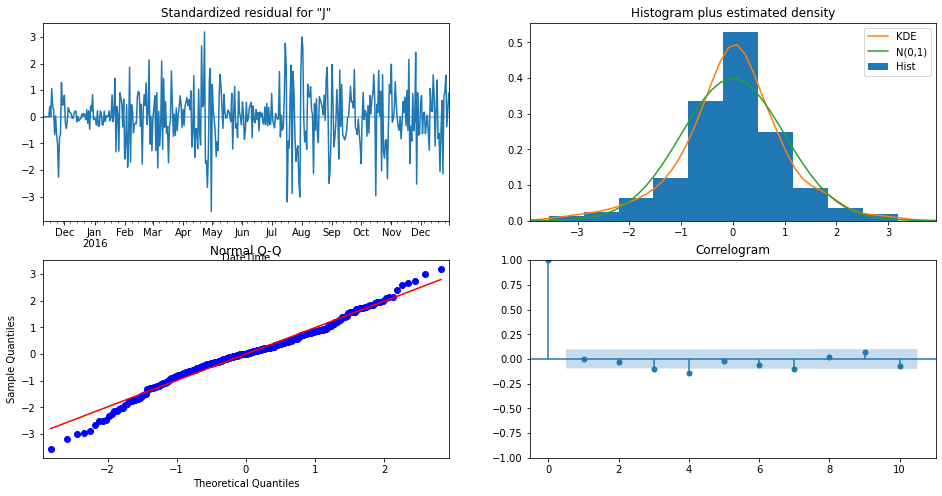

In [215]:
sarimax.plot_diagnostics(figsize=(16, 8))
plt.show()

In [216]:
sarimax_forecast = sarimax.get_forecast(182)
sarimax_forecast_conf_int = sarimax_forecast.conf_int()

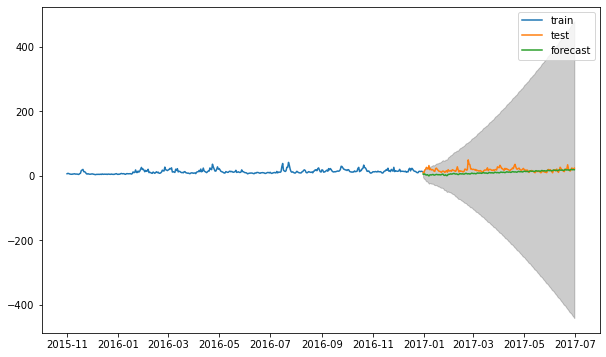

In [217]:
plt.plot(train_data_3, label='train')
plt.plot(test_data_3, label='test')
plt.plot(sarimax_forecast.predicted_mean, label='forecast')


plt.fill_between(sarimax_forecast_conf_int.index,
                 sarimax_forecast_conf_int.iloc[:, 0],
                 sarimax_forecast_conf_int.iloc[:, 1], color='k', alpha=.2)
                 

plt.legend()

In [218]:
s_mse3 = mean_squared_error(test_data_3, sarimax_forecast.predicted_mean)
print('Test MSE: ',s_mse3)

Test MSE:  121.26438886313991


In [219]:
s_rmse3 = np.sqrt(s_mse3)
print('Test RMSE: ',s_rmse3)

Test RMSE:  11.012011118008369


In [220]:
s_mae3 = mean_absolute_error(test_data_3, sarimax_forecast.predicted_mean)
print('Test MAE: ', s_mae3)

Test MAE:  8.83577549013417


## Junction 4

In [221]:
sarimax = SARIMAX(traffic_season_diff_train_4, order=(3,1,2), seasonal_order=(4,1,0,7)).fit()
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         Junction_4   No. Observations:                  127
Model:             SARIMAX(3, 1, 2)x(4, 1, [], 7)   Log Likelihood                -244.934
Date:                            Sun, 04 Apr 2021   AIC                            509.869
Time:                                    20:10:28   BIC                            537.660
Sample:                                01-01-2017   HQIC                           521.154
                                     - 05-07-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6187      0.139     -4.438      0.000      -0.892      -0.345
ar.L2          0.4637      0.133      3.495      0.000       0.204       0.724
ar.L3          0.2476      0.147      1.684      0.092      -0.041       0.536
ma.L1          0.0391      2.842      0.014      0.989      -5.531       5.609
ma.L2         -0.9601      2.713     -0.354      0.723      -6.278       4.358
ar.S.L7       -1.4949      0.110    -13.586      0.000      -1.711      -1.279
ar.S.L14      -1.4692      0.163     -9.002      0.000      -1.789      -1.149
ar.S.L21      -1.1110      0.177     -6.274      0.000      -1.458      -0.764
ar.S.L28      -0.4586      0.100     -4.586      0.000      -0.655      -0.263
sigma2         1.4126      4.002      0.353      0.724      -6.431       9.256
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                23.83
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                             0.70
Prob(H) (two-sided):                  0.71   Kurtosis:                         4.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

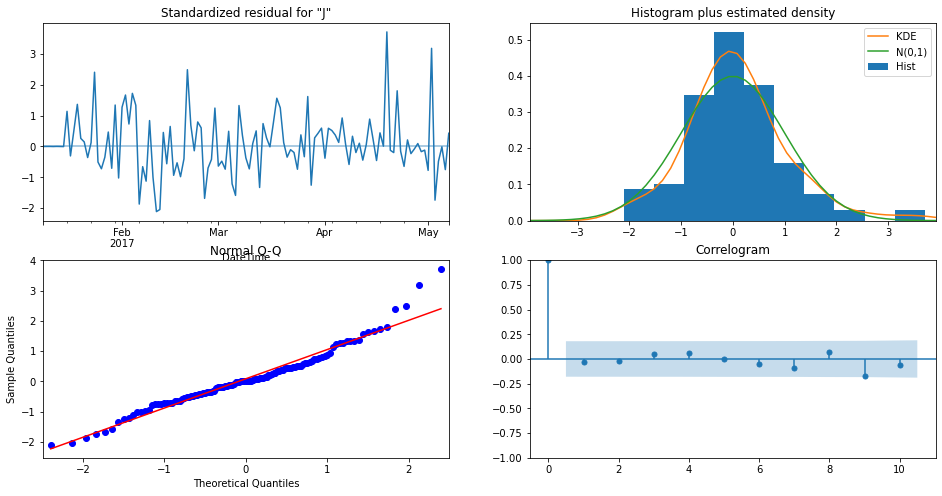

In [222]:
sarimax.plot_diagnostics(figsize=(16, 8))
plt.show()

In [231]:
sarimax_forecast = sarimax.get_forecast(54)
sarimax_forecast_conf_int = sarimax_forecast.conf_int()

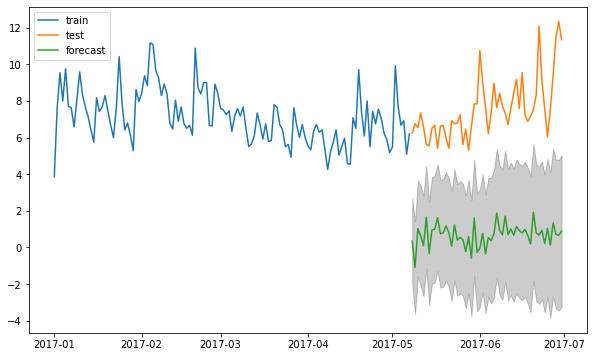

In [232]:
plt.plot(train_data_4, label='train')
plt.plot(test_data_4, label='test')
plt.plot(sarimax_forecast.predicted_mean, label='forecast')


plt.fill_between(sarimax_forecast_conf_int.index,
                 sarimax_forecast_conf_int.iloc[:, 0],
                 sarimax_forecast_conf_int.iloc[:, 1], color='k', alpha=.2)
                 

plt.legend()

In [233]:
s_mse4 = mean_squared_error(test_data_4, sarimax_forecast.predicted_mean)
print('Test MSE: ',s_mse4)

Test MSE:  50.56181457053518


In [234]:
s_rmse4 = np.sqrt(s_mse4)
print('Test RMSE: ',s_rmse4)

Test RMSE:  7.110683129667302


In [235]:
s_mae4 = mean_absolute_error(test_data_4, sarimax_forecast.predicted_mean)
print('Test MAE: ', s_mae4)

Test MAE:  6.896265636743935
